## Ensemble Model Implementation

Having established a strong performance benchmark with our baseline **LogisticRegression** model,  
we now move to implement more advanced ensemble methods.  

### Objective:
- Train each model **with default parameters** initially to quickly evaluate their out-of-the-box performance.
- Identify the most promising model architectures before investing time in hyperparameter tuning.

### Models to be Implemented:
- **Bagging:** `RandomForestClassifier`  
- **Boosting:** `XGBClassifier`  
- **Advanced Boosting:** `CatBoostClassifier`

### Training and Evaluation:
- Models will be trained on the **balanced training data** (using SMOTE).  
- Evaluation will be done on the **imbalanced test set**.  
- Use our **business-focused evaluation framework** (Recall, Precision, F1-Score) for fair and direct comparison against the baseline.


### Import Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from Scripts.business_focused_evaluator import BusinessModelEvaluator
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
                            classification_report,
                            confusion_matrix,
                            accuracy_score,
                            f1_score,
                            precision_score,
                            recall_score,
                            )

### Data Loading

In [2]:
X_train = np.load('../Artifacts/X_train.npz', allow_pickle=True)['arr_0']
Y_train = np.load('../Artifacts/Y_train.npz', allow_pickle=True)['arr_0']
X_test = np.load('../Artifacts/X_test.npz', allow_pickle=True)['arr_0']
Y_test = np.load('../Artifacts/Y_test.npz', allow_pickle=True)['arr_0']

### 1. Random Forest Classifier(Bagging)

### 1.1 Training phase

In [3]:
model_rfc = RandomForestClassifier(
                                    n_estimators=200,
                                    max_depth=10,
                                    min_samples_split=10,
                                    min_samples_leaf=5,
                                    random_state=42,
                                    n_jobs=-1
                                    )

model_rfc.fit(X_train, Y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=10,
                       n_estimators=200, n_jobs=-1, random_state=42)

### 1.2 Inferencing

In [4]:
Y_hat_test = model_rfc.predict(X_test)

### 1.3 Evaluation with primary metrics

In [5]:
precision = precision_score(Y_test, Y_hat_test)
recall = recall_score(Y_test, Y_hat_test)
F1_score = f1_score(Y_test, Y_hat_test)

In [8]:
print("\n----Random Forest Classifier----")
print(f"precision : {precision}")
print(f"Recall : {recall}")
print(f"F1_score : {F1_score} ")


----Random Forest Classifier----
precision : 0.5640495867768595
Recall : 0.7319034852546917
F1_score : 0.6371061843640606 


### 1.4 Evaluate with Business Focussed Metrics

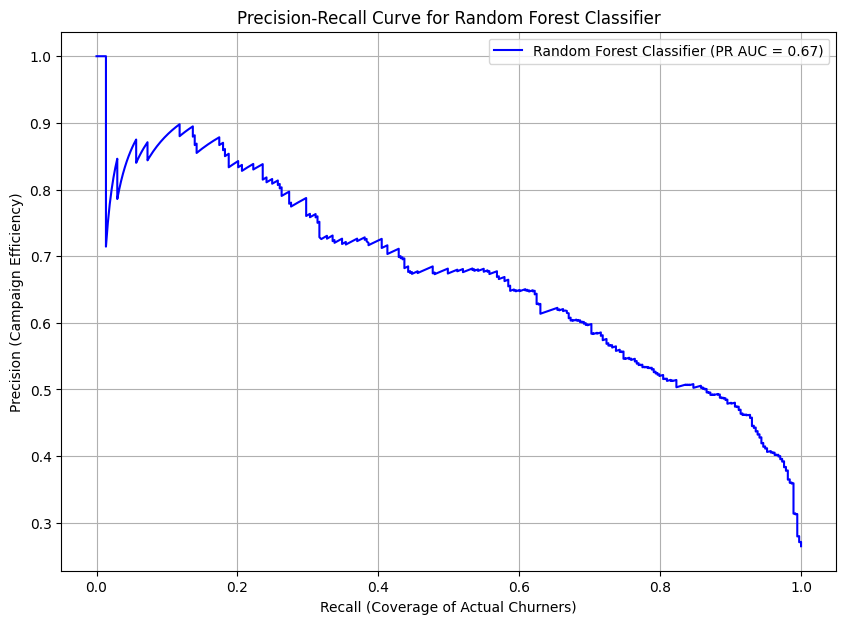

Precision-Recall AUC for Random Forest Classifier: 0.6722

--- Cost-Sensitive Analysis at Threshold = 0.5 ---
False Positives (FP): 211 -> Cost: $10,550.00
False Negatives (FN): 100 -> Cost: $200,000.00
Total Business Cost: $210,550.00

--- Threshold Optimization ---
Optimal Threshold for Minimum Business Cost: 0.1064
Minimum Achievable Business Cost: $40,900.00

--- Cost-Sensitive Analysis at Threshold = 0.10637320769189883 ---
False Positives (FP): 658 -> Cost: $32,900.00
False Negatives (FN): 4 -> Cost: $8,000.00
Total Business Cost: $40,900.00


np.int64(40900)

In [9]:
COST_FP = 50
COST_FN = 2000

y_probs_rfc = model_rfc.predict_proba(X_test)[: , 1]

# create instnce of the evaluator for model_rfc
rfc_evaluator = BusinessModelEvaluator(
                                    Y_test,
                                    y_probs_rfc,
                                    'Random Forest Classifier'
                                    )

rfc_evaluator.plot_precision_recall_curve()
rfc_evaluator.cost_sensitive_analysis(cost_fp=COST_FP, cost_fn=COST_FN) 
optimal_thresh, min_cost = rfc_evaluator.find_optimal_threshold(cost_fp=COST_FP, cost_fn=COST_FN)
rfc_evaluator.cost_sensitive_analysis(cost_fp=COST_FP, cost_fn=COST_FN, threshold=optimal_thresh) 